In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle

pd.set_option('display.max_rows', None)

In [2]:
df_base = pickle.load(open("../results/df_base.pkl","rb"))
vars_naturaleza = pickle.load(open("../results/vars_naturaleza.pkl","rb"))

In [3]:
diccionario_variables = pd.read_excel("../data/diccionario_filtrado.xlsx", sheet_name="variables")
dict_desc = dict(zip(diccionario_variables['id_variable'],diccionario_variables['descripcion']))

In [4]:
vars_num = vars_naturaleza['vars_numericas']
vars_bin = [v for v in vars_naturaleza['vars_binarias'] if v not in vars_naturaleza['vars_agrupadas']]
vars_ord = vars_naturaleza['vars_ordinales']
vars_discre = vars_naturaleza['vars_discretas']

In [5]:
len(vars_ord)

47

In [6]:
df_base['DEPMUNI'].value_counts()

DESCONOCIDO       13027
CENTRO POBLADO    11880
BARRANQUILLA       6134
MONTERIA           5794
CARTAGENA          5753
CUCUTA             5160
BOGOTA             5114
BUCARAMANGA        4989
IBAGUE             4984
MEDELLIN           4877
VILLAVICENCIO      4855
PEREIRA            4780
MANIZALES          4771
CALI               4571
PASTO              4533
Name: DEPMUNI, dtype: int64

In [7]:
df_base = df_base[df_base['DEPMUNI'].isin(['BOGOTA','MEDELLIN','CALI'])]
df_base.shape

(14562, 222)

In [8]:
df_base.shape

(14562, 222)

#### Solo variables numéricas

In [9]:
df_base_t = pd.DataFrame()

In [10]:
for var in vars_ord:
    df_base_t[var] = (df_base[var].astype(float) - 0.5)/len(set(df_base[var]))

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_base_t[vars_num + vars_ord] = scaler.fit_transform(df_base[vars_num + vars_ord])

In [12]:
df_base_t.shape

(14562, 63)

#### Agregando categóricas

In [13]:
df_base_t2 = pd.DataFrame()

for var in vars_ord:
    df_base_t2[var] = (df_base[var].astype(float) - 0.5)/len(set(df_base[var]))
    
df_base_t2[vars_num + vars_ord] = scaler.fit_transform(df_base[vars_num + vars_ord])    

In [14]:
df_base_t2[vars_bin] = df_base[vars_bin]
df_base_t2[vars_discre] = df_base[vars_discre]

In [15]:
df_base_t2.shape

(14562, 71)

### PCA variables numéricas y ordinales

In [16]:
from pca import pca

model = pca()
pca_result = model.fit_transform(df_base_t, verbose=False)

In [17]:
def plot_pca(var_explicada, var_acumulada, corte=0.7):
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,10))
    xi = np.arange(1, len(var_acumulada)+1, step=1)
    y = var_acumulada

    ax1.set_ylim(0.0,1.1)
    ax1.plot(xi, y, marker='o', linestyle='-', color='black')

    ax1.set_xlabel('Componente principal')
    ax1.set_xticks(np.arange(1, len(var_acumulada)+1, step=1)) 
    ax1.set_ylabel('Proporción de varianza explicada acumulada')
    ax1.set_title('Varianza explicada acumulada')

    ax1.axhline(y=corte, color='grey', linestyle='--')
    ax1.text(0.8, corte+0.01, '{}% umbral de corte'.format(round(corte*100)), color = 'black', fontsize=8)
    ax1.grid(axis='x')

    y = var_explicada

    ax2.plot(xi, y, marker='o', linestyle='-', color='black')
    ax2.set_xlabel('Componente principal')
    ax2.set_xticks(np.arange(1, len(var_acumulada)+1, step=1)) 
    ax2.set_ylabel('Proporción varianza explicada')
    ax2.set_title('Varianza explicada')

    ax2.grid(axis='x')
    plt.tight_layout()
    plt.show()      

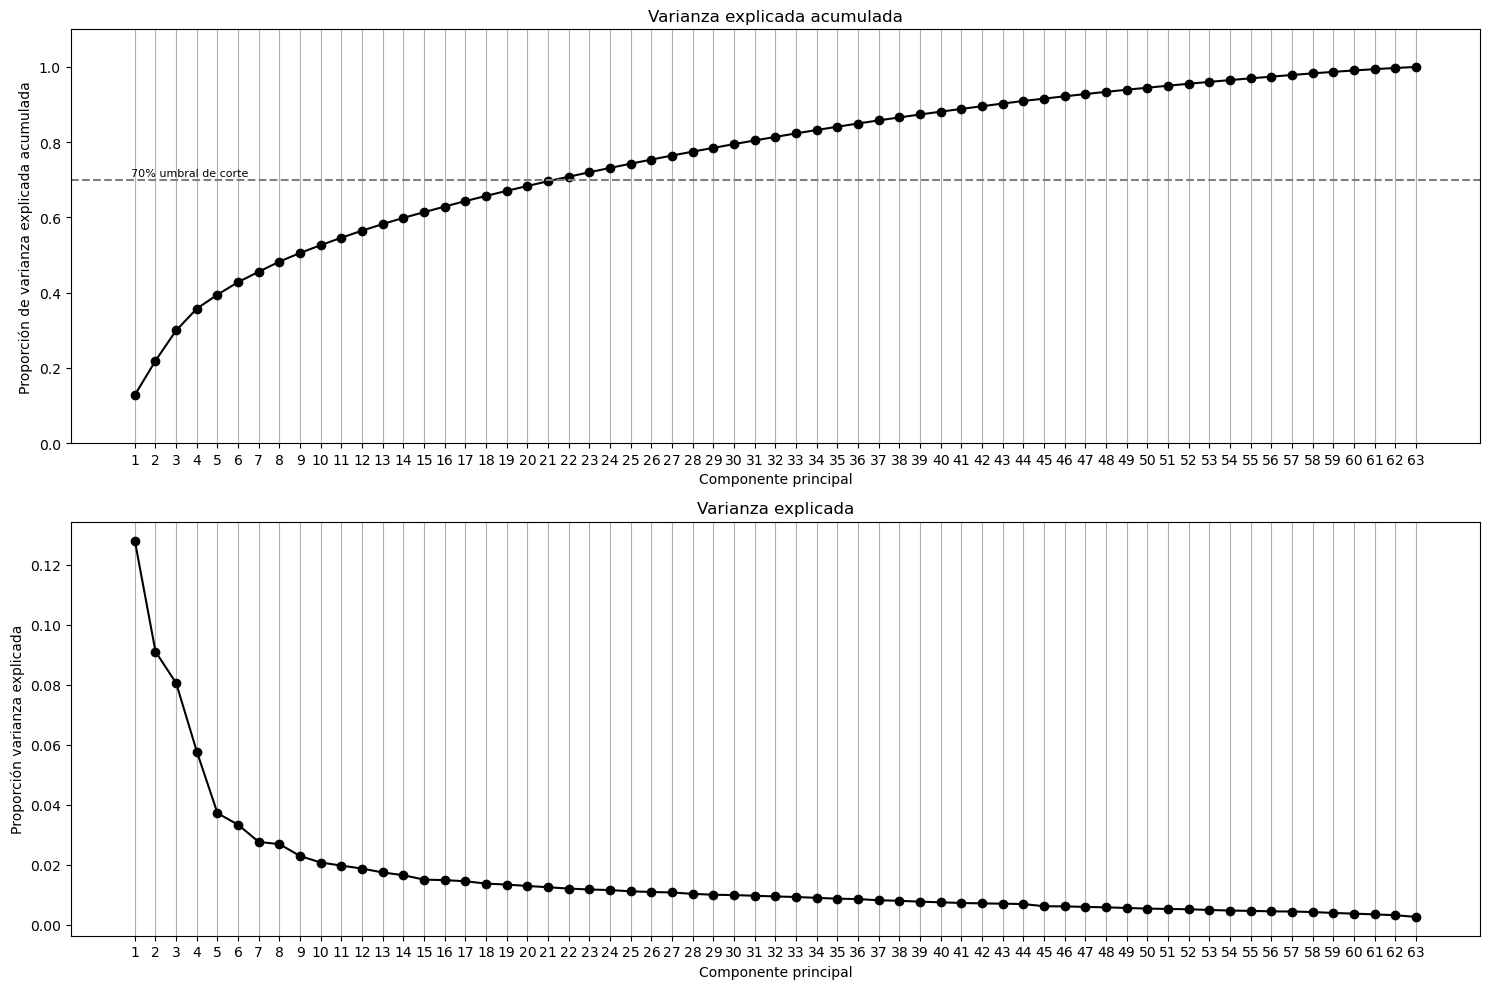

In [18]:
plot_pca(pca_result['variance_ratio'],pca_result['explained_var'])

In [19]:
n_componentes = 7

In [20]:
df_pca = pca_result['PC'].iloc[:,:n_componentes]

In [21]:
pca_result['topfeat'].head(7)

,PC,feature,loading,type
0,PC1,P3113S3,0.200116,best
1,PC2,P1906S7,-0.284909,best
2,PC3,P3317S3,-0.276705,best
3,PC4,P3111S6,-0.231636,best
4,PC5,P3111S8,-0.272457,best
5,PC6,P6210,0.304816,best
6,PC7,P3119,0.387008,best


[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


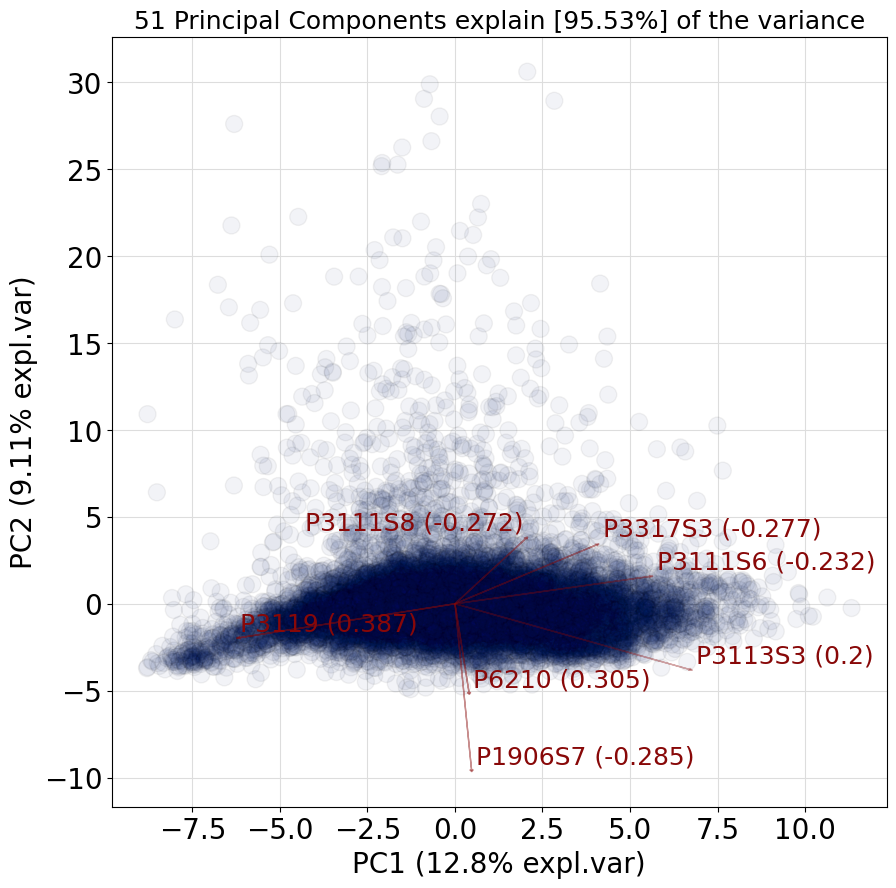

In [22]:
import matplotlib 

# Creamos el biplot
fig, ax = model.biplot(n_feat=7, legend=False, figsize=(10,10), alpha=0.05)

In [23]:
cols = pca_result['loadings'].T.iloc[:,:n_componentes]

In [24]:
cols['max'] = cols.apply(lambda v: np.argmax(abs(v)),axis=1)

In [25]:
for i in range(n_componentes):
    pc=i
    vars_pc = pd.DataFrame(cols[cols['max'] == pc]["PC{}".format(pc+1)]).reset_index()
    vars_pc.columns = ["variable","PC"]
    vars_pc['ABS_PC'] = vars_pc['PC'].abs()
    vars_pc = vars_pc.sort_values("ABS_PC", ascending=False)
    print("\nVariables que influyen en componente {}".format(i+1),"\n")
    for i,r in vars_pc.iterrows():
        print("Variable:",r['variable'], dict_desc.get(r['variable'],""), "\nloading:", r['PC'],"\n")


Variables que influyen en componente 1 

Variable: P3113S3 c. Venta de celulares o equipos robados o extraviados 
loading: 0.2001160552040644 

Variable: inseguro_ciudad  
loading: 0.1989933888648167 

Variable: P3113S20 t. Compra y venta de artículos hurtados 
loading: 0.19644880269492979 

Variable: problema_barrio  
loading: 0.19203136930024164 

Variable: P3113S10 j. Presencia de vendedores de sustancias psicoactivas 
loading: 0.18386118171709964 

Variable: P3113S4 d. Irrespeto hacia las autoridades de Policía 
loading: 0.18363544947504662 

Variable: P3113S1 j. Presencia de vendedores de sustancias psicoactivas 
loading: 0.1802905189697654 

Variable: P3113S21 u. Casos de extorsiones 
loading: 0.1758466928086214 

Variable: P3113S8 h. Casos de violencia intrafamiliar 
loading: 0.17466561512752382 

Variable: P3113S22 v. Detrimento al patrimonio nacional 
loading: 0.1635126429713143 

Variable: P3111S1 10. Con respecto a la seguridad, ¿cómo se siente ... en los siguientes lugares

### Kmeans

In [26]:
from sklearn.metrics import silhouette_score

varianza_intra_cluster = []
silhouettes = []
for k in range (1, 11): # Evaluamos entre 1 a 10 clusters posibles
    print(f"Entrenando {k} clusters...")
    kmeans = KMeans(n_clusters = k, random_state = 123, n_init=10).fit(df_pca)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(df_pca, kmeans.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)

Entrenando 1 clusters...
Entrenando 2 clusters...
Entrenando 3 clusters...
Entrenando 4 clusters...
Entrenando 5 clusters...
Entrenando 6 clusters...
Entrenando 7 clusters...
Entrenando 8 clusters...
Entrenando 9 clusters...
Entrenando 10 clusters...


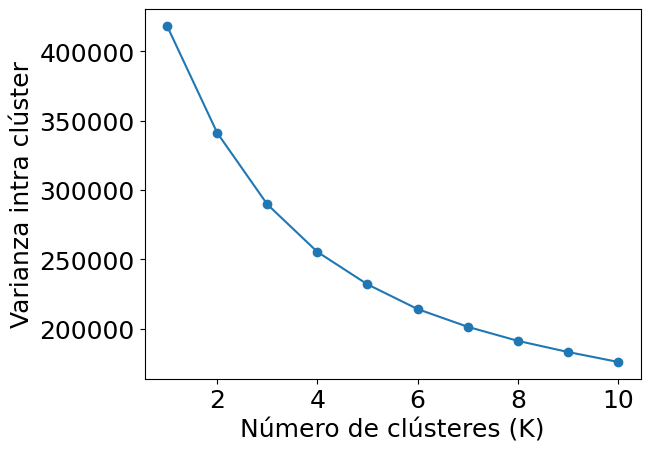

In [27]:
plt.plot(range(1, 11), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

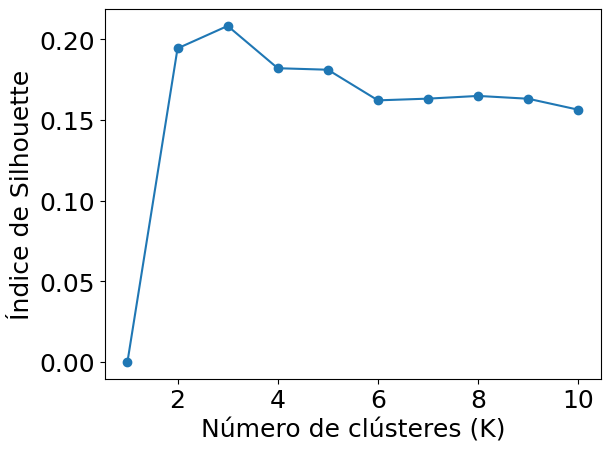

In [28]:
plt.plot(range(1, 11), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.show()

In [29]:
kmeans = KMeans(n_clusters = 3, random_state = 123, n_init=10).fit(df_pca)

In [30]:
pd.DataFrame(kmeans.labels_).value_counts()

2    8253
1    5980
0     329
dtype: int64

In [31]:
from yellowbrick.cluster import SilhouetteVisualizer

In [32]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', fitted=True)

C:\Anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


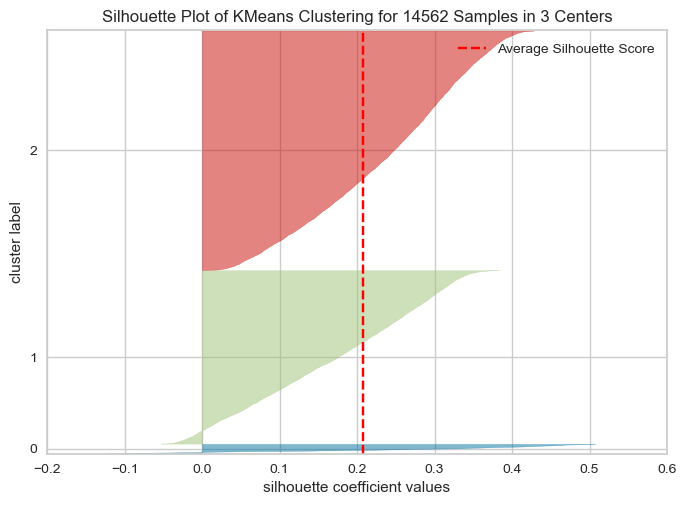

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 14562 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
visualizer.fit(df_pca)
visualizer.show()

In [34]:
df_pca['cluster'] = kmeans.labels_

C:\Users\aserna\AppData\Local\Temp\ipykernel_3272\1549373690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca['cluster'] = kmeans.labels_


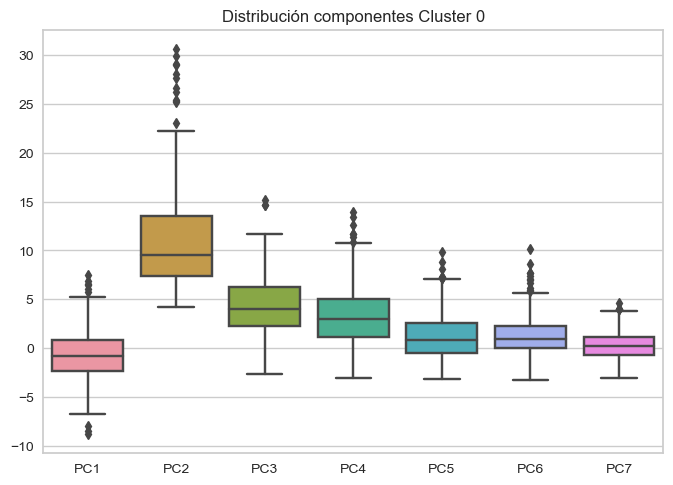

In [35]:
sns.boxplot(df_pca.query("cluster==0").drop(columns="cluster"))
plt.title("Distribución componentes Cluster 0")
plt.show()

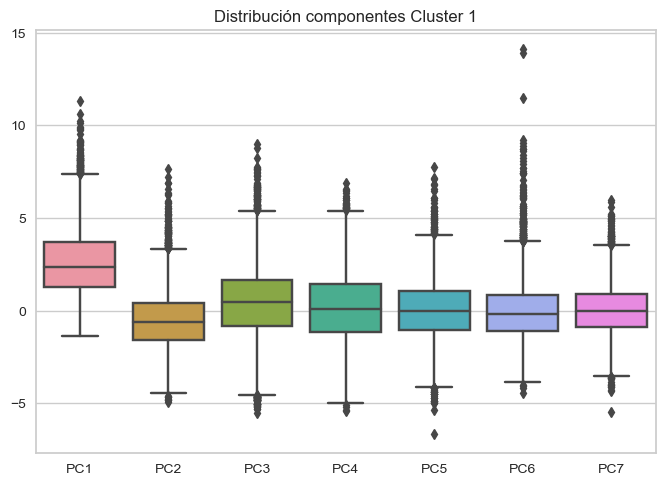

In [36]:
sns.boxplot(df_pca.query("cluster==1").drop(columns="cluster"))
plt.title("Distribución componentes Cluster 1")
plt.show()

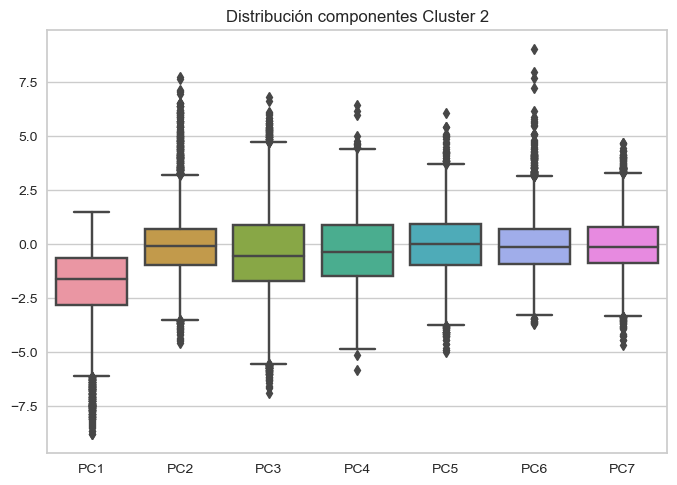

In [37]:
sns.boxplot(df_pca.query("cluster==2").drop(columns="cluster"))
plt.title("Distribución componentes Cluster 2")
plt.show()

In [38]:
from sklearn.metrics import silhouette_score

varianza_intra_cluster = []
silhouettes = []
for k in range (1, 11): # Evaluamos entre 1 a 10 clusters posibles
    print(f"Entrenando {k} clusters...")
    kmeans = KMeans(n_clusters = k, random_state = 123, n_init=10).fit(df_base_t)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(df_base_t, kmeans.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)

Entrenando 1 clusters...
Entrenando 2 clusters...
Entrenando 3 clusters...
Entrenando 4 clusters...
Entrenando 5 clusters...
Entrenando 6 clusters...
Entrenando 7 clusters...
Entrenando 8 clusters...
Entrenando 9 clusters...
Entrenando 10 clusters...


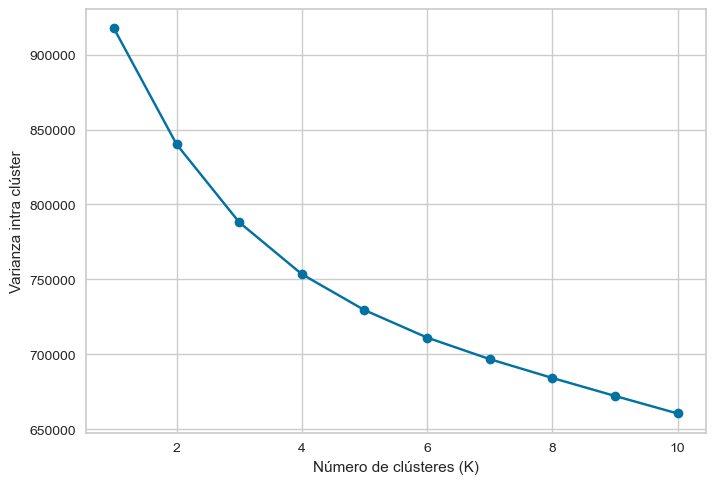

In [39]:
plt.plot(range(1, 11), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

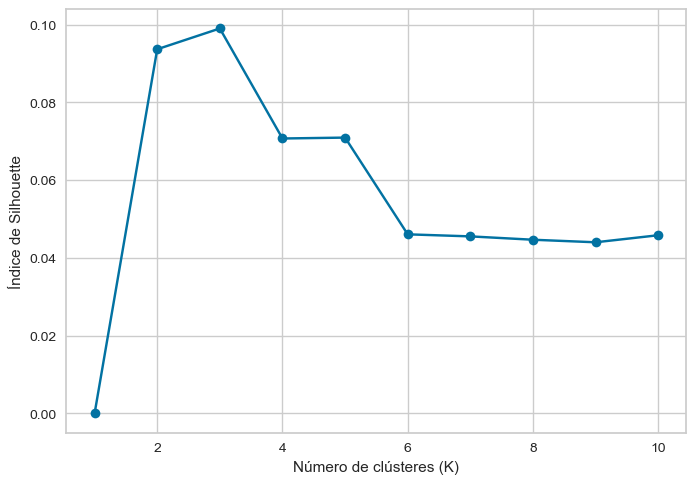

In [40]:
plt.plot(range(1, 11), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.show()

In [41]:
kmeans = KMeans(n_clusters = 3, random_state = 123, n_init=10).fit(df_base_t)

In [42]:
pd.DataFrame(kmeans.labels_).value_counts()

1    8240
2    6021
0     301
dtype: int64

C:\Anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


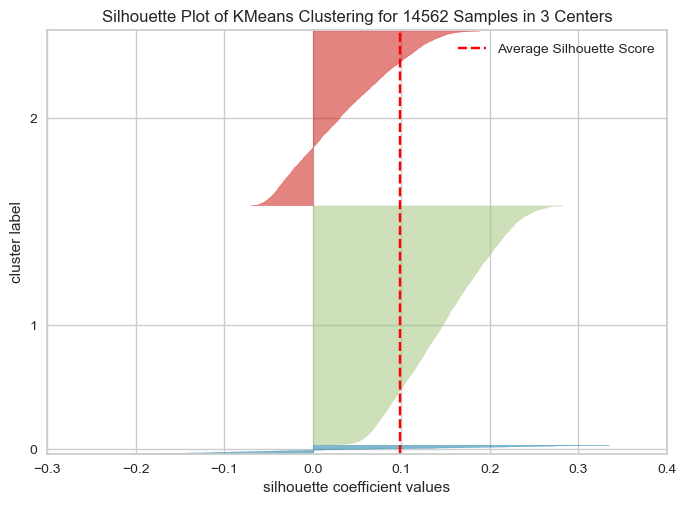

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 14562 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', fitted=True)
visualizer.fit(df_base_t)
visualizer.show()

### Kmedoids

In [44]:
from sklearn_extra.cluster import KMedoids 

varianza_intra_cluster = []
silhouettes = []
for k in range (1, 11): # Evaluamos entre 1 a 10 clusters posibles
    print(f"Entrenando {k} clusters...")
    Kmedoides = KMedoids(n_clusters = k, random_state = 123).fit(df_pca)
    varianza_intra_cluster.append(Kmedoides.inertia_)
    try:
        silhouette = silhouette_score(df_pca, Kmedoides.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)

Entrenando 1 clusters...
Entrenando 2 clusters...
Entrenando 3 clusters...
Entrenando 4 clusters...
Entrenando 5 clusters...
Entrenando 6 clusters...
Entrenando 7 clusters...
Entrenando 8 clusters...
Entrenando 9 clusters...
Entrenando 10 clusters...


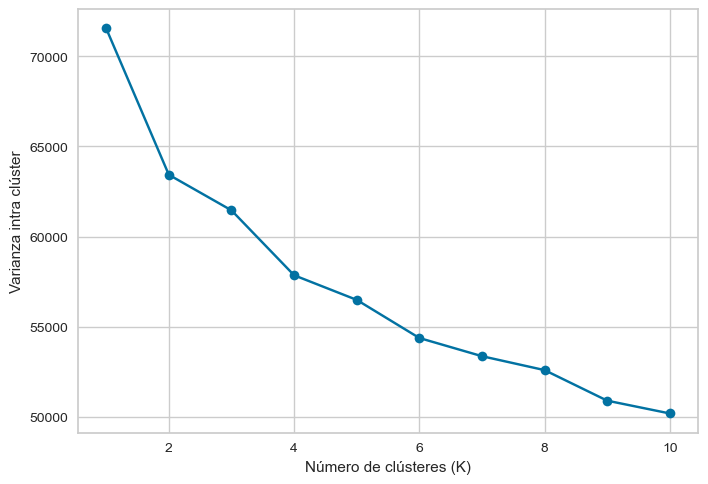

In [45]:
plt.plot(range(1, 11), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

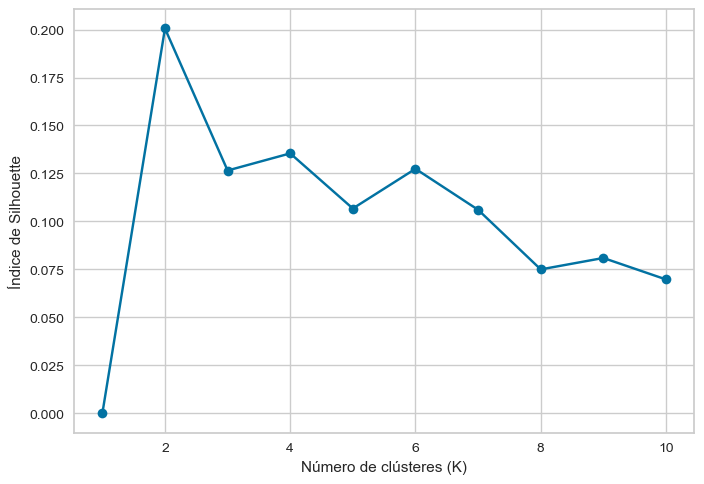

In [46]:
plt.plot(range(1, 11), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.show()

In [47]:
Kmedoides = KMedoids(n_clusters = 2, random_state = 123).fit(df_pca)

In [48]:
pd.DataFrame(Kmedoides.labels_).value_counts()

0    8749
1    5813
dtype: int64

In [49]:
from sklearn_extra.cluster import KMedoids 

varianza_intra_cluster = []
silhouettes = []
for k in range (1, 11): # Evaluamos entre 1 a 10 clusters posibles
    print(f"Entrenando {k} clusters...")
    Kmedoides = KMedoids(n_clusters = k, random_state = 123).fit(df_base_t)
    varianza_intra_cluster.append(Kmedoides.inertia_)
    try:
        silhouette = silhouette_score(df_base_t, Kmedoides.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)

Entrenando 1 clusters...
Entrenando 2 clusters...
Entrenando 3 clusters...
Entrenando 4 clusters...
Entrenando 5 clusters...
Entrenando 6 clusters...
Entrenando 7 clusters...
Entrenando 8 clusters...
Entrenando 9 clusters...
Entrenando 10 clusters...


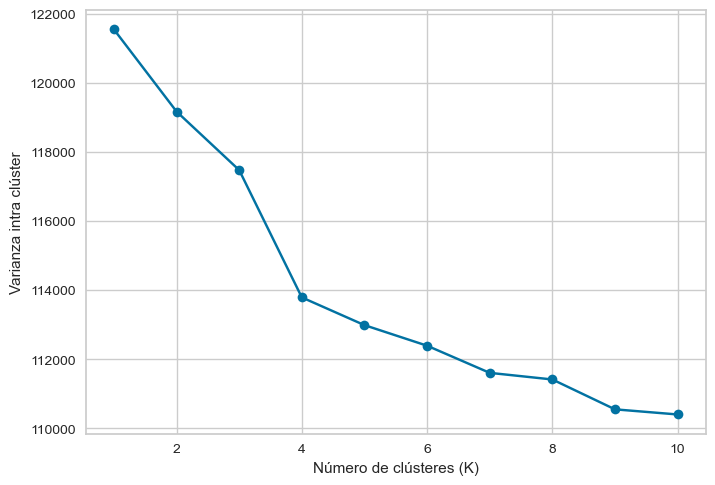

In [50]:
plt.plot(range(1, 11), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

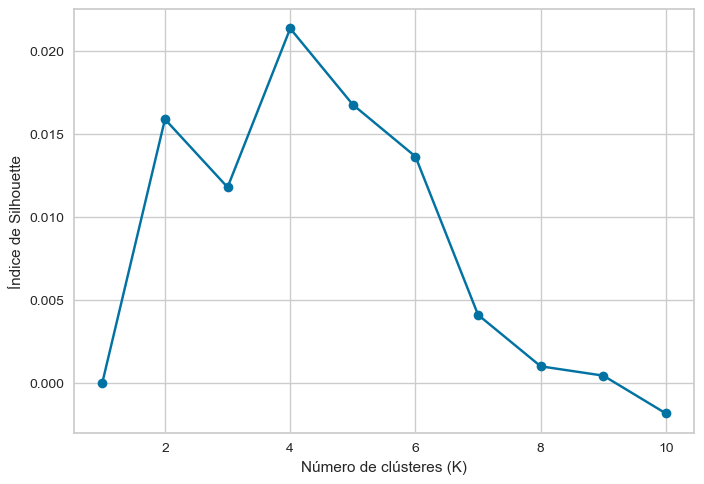

In [51]:
plt.plot(range(1, 11), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.show()

In [52]:
Kmedoides = KMedoids(n_clusters = 4, random_state = 123).fit(df_base_t)

In [53]:
pd.DataFrame(Kmedoides.labels_).value_counts()

0    4165
2    3928
3    3740
1    2729
dtype: int64

In [54]:
from sklearn.cluster import AgglomerativeClustering

In [55]:
clustering = AgglomerativeClustering(n_clusters=3).fit(df_pca)

In [56]:
pd.DataFrame(clustering.labels_).value_counts()

0    10897
2     3123
1      542
dtype: int64

In [57]:
clustering = AgglomerativeClustering(n_clusters=3).fit(df_base_t)

In [58]:
pd.DataFrame(clustering.labels_).value_counts()

0    7217
1    7053
2     292
dtype: int64

### DBSCAN

In [59]:
min_samples= 2*df_pca.shape[1]
min_samples

16

In [60]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

neigh = NearestNeighbors(n_neighbors = min_samples)
nbrs = neigh.fit(df_pca)
distancias, indices = nbrs.kneighbors(df_pca)
distancias = np.sort(distancias.flatten())

i = np.arange(len(distancias))
knee = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')

eps = distancias[knee.knee]
eps

2.2468617452344444

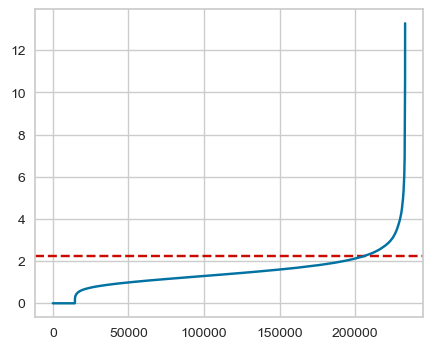

In [61]:
fig=plt.figure(figsize=(5,4), dpi= 100, facecolor='w', edgecolor='k')
plt.axhline(y = eps, color = 'r', linestyle = '--')
plt.plot(distancias)
plt.show()

In [62]:
db = DBSCAN(eps = eps, min_samples = min_samples).fit(df_pca)
clusteres = db.labels_
n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
n_clusteres

1

<Axes: xlabel='PC1', ylabel='PC2'>

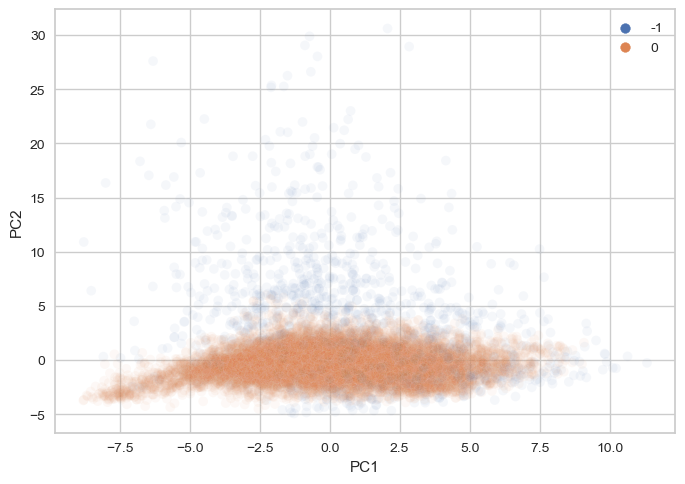

In [63]:
sns.scatterplot(data=df_pca, x="PC1", y="PC2", alpha=0.05, hue=clusteres, palette='deep')

In [64]:
pd.DataFrame(clusteres).value_counts()

 0    13363
-1     1199
dtype: int64

In [65]:
min_samples= 2*df_base_t.shape[1]
min_samples

126

In [66]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

neigh = NearestNeighbors(n_neighbors = min_samples)
nbrs = neigh.fit(df_base_t)
distancias, indices = nbrs.kneighbors(df_base_t)
distancias = np.sort(distancias.flatten())

i = np.arange(len(distancias))
knee = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')

eps = distancias[knee.knee]
eps

8.461442985799573

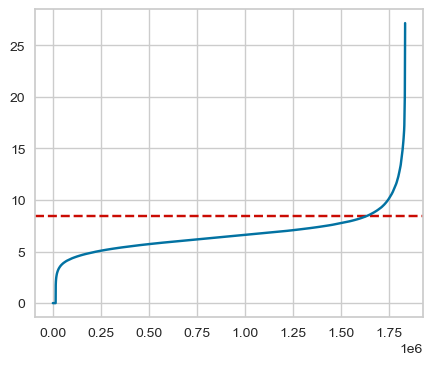

In [67]:
fig=plt.figure(figsize=(5,4), dpi= 100, facecolor='w', edgecolor='k')
plt.axhline(y = eps, color = 'r', linestyle = '--')
plt.plot(distancias)
plt.show()

In [68]:
db = DBSCAN(eps = eps, min_samples = min_samples).fit(df_base_t)
clusteres = db.labels_
n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
n_clusteres

1

In [69]:
pd.DataFrame(clusteres).value_counts()

 0    13812
-1      750
dtype: int64

# PCA con variables mixtas

In [70]:
from prince import FAMD

In [71]:
famd = FAMD(n_components=df_base_t2.shape[1], n_iter = 3, random_state = 101)
df_famd = famd.fit_transform(df_base_t2)

In [72]:
df_famd.head()

component,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
4272,-3.285581,-0.284630,-1.841349,-0.079335,2.587610,-1.972075,-2.178481,0.503833,-1.587655,-1.186488,...,-0.175340,0.121964,1.119971,0.431927,-0.242279,0.172125,-0.051681,-0.401487,0.304738,-0.203565
4273,-5.043261,10.176248,-3.789326,0.548591,1.055129,4.342468,-2.834337,1.594791,-1.764438,-2.686876,...,-2.606872,-1.260156,1.749273,0.490864,-0.145640,-0.214409,0.599467,-0.455654,0.070109,-0.386823
4274,1.281249,2.050372,0.325203,2.199410,2.983466,-0.759898,-0.010936,1.944078,-0.629189,-1.665721,...,1.079189,-1.352132,0.547609,1.720933,-0.813808,0.300276,-0.185977,1.049885,0.019377,-0.357678
4275,0.613720,0.864710,0.461056,3.135483,5.243011,0.509063,-0.786139,1.743514,-1.051770,-1.728082,...,-0.453092,0.348378,1.023141,0.648456,0.194203,0.357435,-0.226007,-0.527558,-0.530604,-0.896890
4276,3.326649,-0.992346,-0.262951,8.480480,-0.686101,1.142919,-6.625848,9.608781,-7.263374,8.838778,...,0.340885,-1.734599,-0.511815,0.518905,-0.152439,0.361820,0.514827,0.658870,-0.243165,0.503199


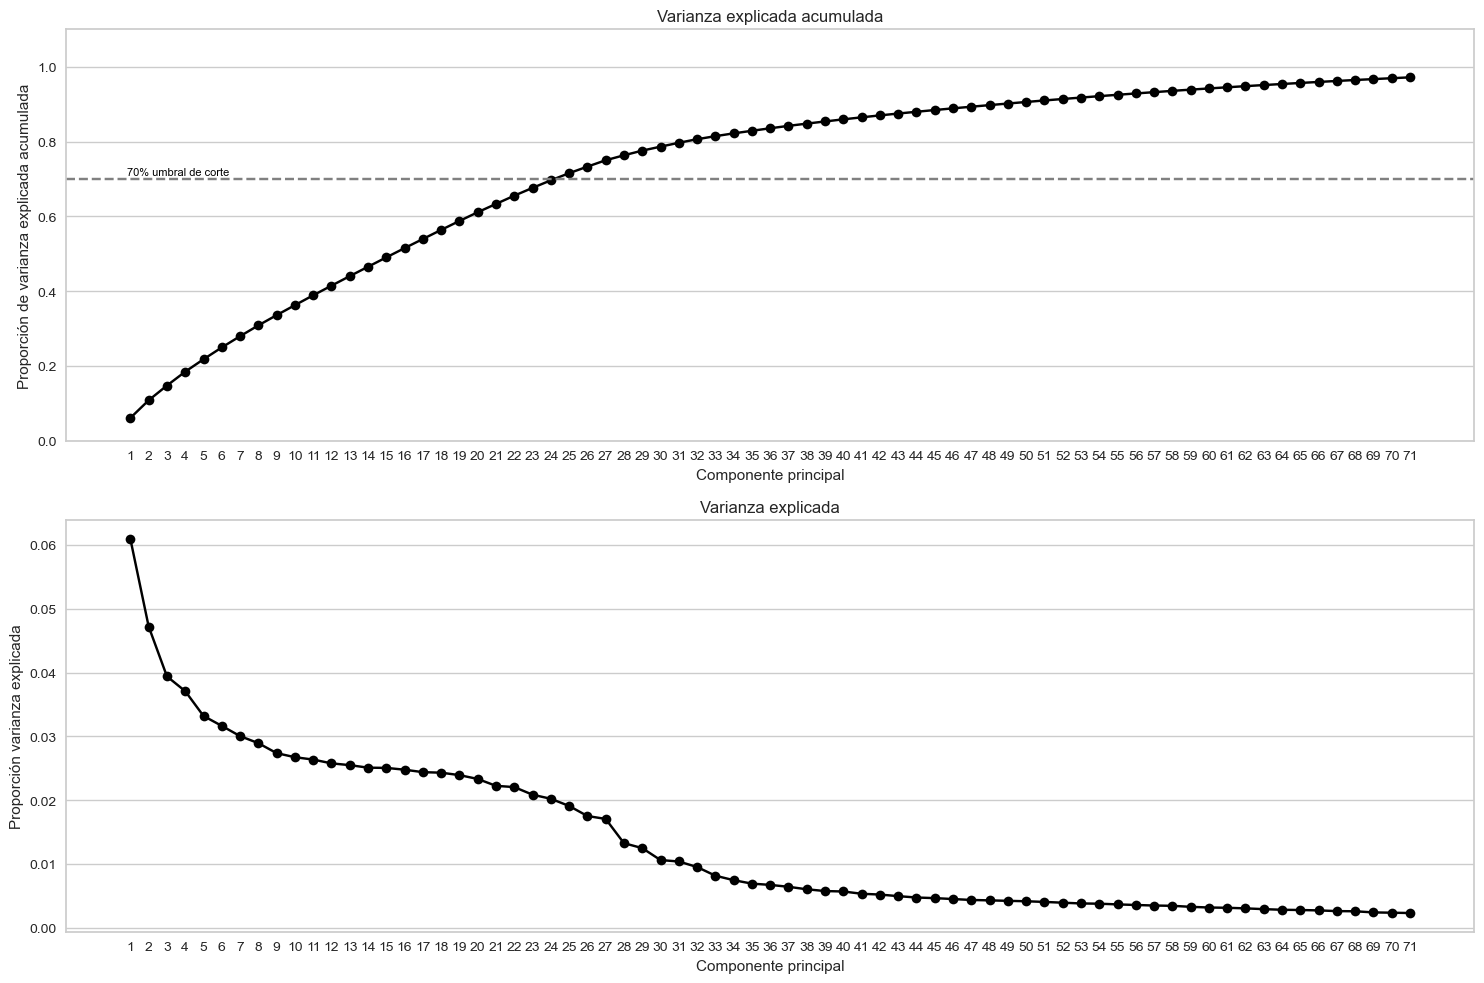

In [73]:
plot_pca(famd.percentage_of_variance_/100,famd.cumulative_percentage_of_variance_/100)

In [74]:
n_componentes = 5

In [75]:
cols = famd.column_coordinates_.iloc[:,:n_componentes].copy()

In [76]:
cols['max'] = cols.apply(lambda v: np.argmax(abs(v)),axis=1)

In [77]:
for i in range(n_componentes):
    pc=i
    vars_pc = pd.DataFrame(cols[cols['max'] == pc][pc]).reset_index()
    vars_pc.columns = ["variable","PC"]
    vars_pc['ABS_PC'] = vars_pc['PC'].abs()
    vars_pc = vars_pc.sort_values("ABS_PC", ascending=False)
    print("\nVariables que influyen en componente {}".format(i+1),"\n")
    for i,r in vars_pc.iterrows():
        print("Variable:",r['variable'], dict_desc.get(r['variable'],""), "\nloading:", r['PC'],"\n")


Variables que influyen en componente 1 

Variable: inseguro_ciudad  
loading: 0.36385778102709015 

Variable: problema_barrio  
loading: 0.31702093586283253 

Variable: P3105 1. En general, ¿qué tan seguro(a) se siente ... en el barrio o vereda ...: 
loading: 0.30250976510334354 

Variable: inseguro_barrio  
loading: 0.2896991482210514 

Variable: P3107 5. En general, ¿qué tan seguro(a) se siente ... en la ciudad o municipio de ...: 
loading: 0.27864135758729897 

Variable: P3113S3 c. Venta de celulares o equipos robados o extraviados 
loading: 0.27840634489901855 

Variable: P3113S4 d. Irrespeto hacia las autoridades de Policía 
loading: 0.26869399252263404 

Variable: P3111S6 10. Con respecto a la seguridad, ¿cómo se siente ... en los siguientes lugares (muy seguro(a), seguro(a), inseguro(a), muy inseguro(a)):
f. En vía pública: 
loading: 0.26505031371065707 

Variable: P3113S1 j. Presencia de vendedores de sustancias psicoactivas 
loading: 0.24928752067664825 

Variable: P3113S20 t

In [78]:
df_famd = df_famd.iloc[:,:n_componentes]

In [79]:
from sklearn.metrics import silhouette_score

varianza_intra_cluster = []
silhouettes = []
for k in range (1, 11): # Evaluamos entre 1 a 10 clusters posibles
    print(f"Entrenando {k} clusters...")
    kmeans = KMeans(n_clusters = k, random_state = 123, n_init=10).fit(df_famd)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(df_famd, kmeans.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)

Entrenando 1 clusters...
Entrenando 2 clusters...
Entrenando 3 clusters...
Entrenando 4 clusters...
Entrenando 5 clusters...
Entrenando 6 clusters...
Entrenando 7 clusters...
Entrenando 8 clusters...
Entrenando 9 clusters...
Entrenando 10 clusters...


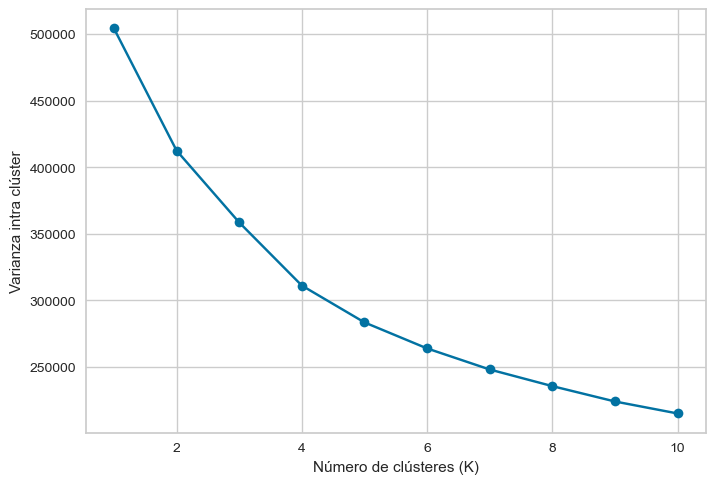

In [80]:
plt.plot(range(1, 11), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

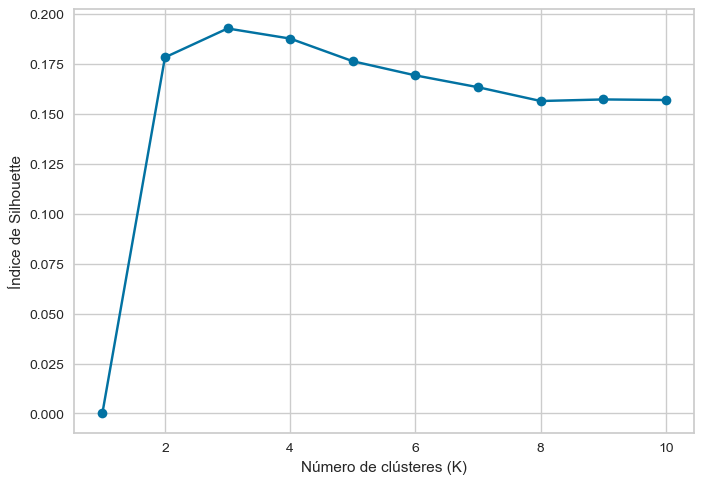

In [81]:
plt.plot(range(1, 11), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.show()

In [82]:
kmeans = KMeans(n_clusters = 3, random_state = 123, n_init=10).fit(df_famd)

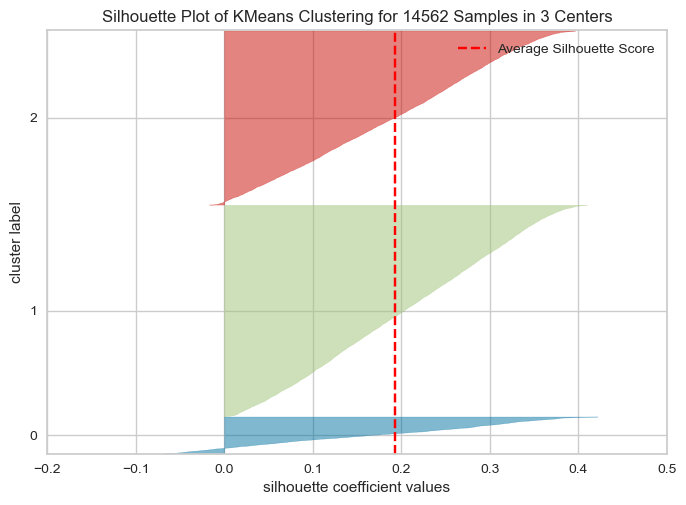

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 14562 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [83]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', fitted=True)
visualizer.fit(df_famd)
visualizer.show()